In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
from IPython.display import display

import seaborn as sns
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

plt.style.use("seaborn-pastel")
plt.rcParams['figure.figsize'] = (10, 7)

In [2]:
df = pd.read_csv('data/streaming_history.csv', parse_dates=['endTime'])
tracks_df = pd.read_csv('data/tracks.csv', parse_dates=['album_release_date'])
features_df = pd.read_csv('data/features.csv')

df.dropna(inplace=True)

df = df.merge(tracks_df, left_on='id_', right_on='id_', suffixes=('stream_', 'track_'))\
       .merge(features_df, left_on='id_', right_on='id_', suffixes=('stream_', 'feature_'))

In [3]:
cols = [
    'popularity', 'danceability', 'energy', 'key', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]

In [4]:
df = df.groupby('artist+track').aggregate({col: 'min' for col in cols})

In [5]:
# norm_df = ((df - df.mean()) / df.std())
norm_df = ((df - df.min()) / (df.max() - df.min()))

<AxesSubplot:>

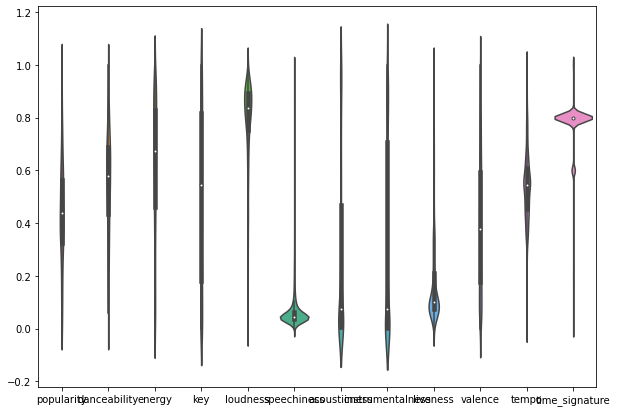

In [6]:
sns.violinplot(data=norm_df)

In [7]:
filter_outliers_cond = ((norm_df.quantile(0.02) <= norm_df) & 
                        (norm_df <= norm_df.quantile(0.98)))\
                       .all(axis=1)
display('Percent of records with at least one outlier feature '
        f'{(1 - filter_outliers_cond.sum() / norm_df.shape[0]) * 100 :.2f}%')
norm_df = norm_df[filter_outliers_cond]

'Percent of records with at least one outlier feature 28.96%'

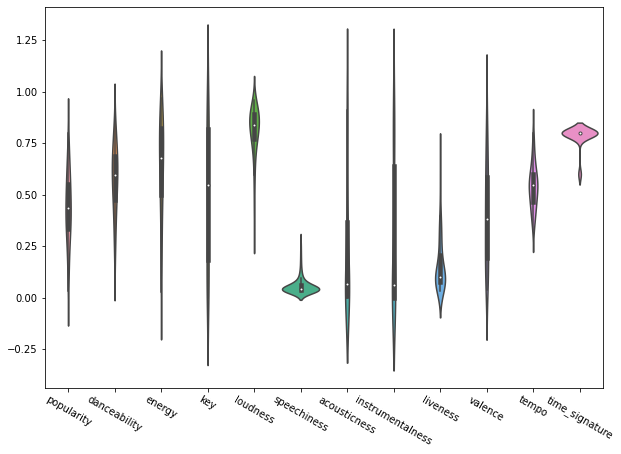

In [8]:
ax = sns.violinplot(data=norm_df, bw=.5)
plt.xticks(rotation=-30);

<ipython-input-9-250ff55cfce6>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


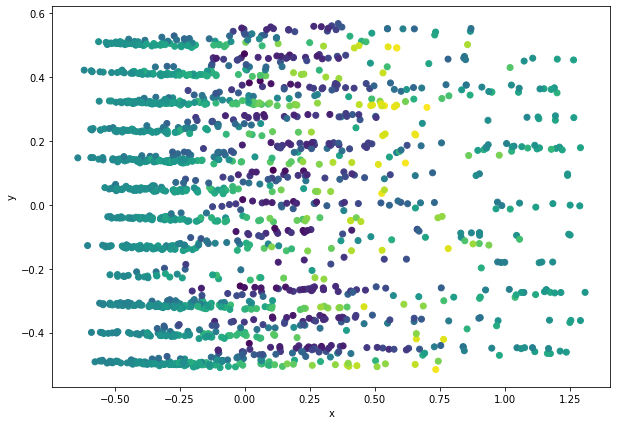

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(norm_df.copy())
pca_df=pd.DataFrame(pca_result)

fig = plt.figure()
ax = fig.add_subplot(111)

scatter = ax.scatter(pca_df.iloc[:, 0].values, pca_df.iloc[:, 1].values,
                     c=pca_df.iloc[:, 2].values)
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.show()

In [10]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

algorithms = {
    DBSCAN: {
        'eps': (0.05, 3.),
        'min_samples': (3, 100),
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': (3, 100)
    },
    KMeans: {
        'n_clusters': (2, 20),
    },
    AgglomerativeClustering: {
        'n_clusters': (2, 20),
        'affinity': ["euclidean", "l1", "l2", "manhattan", "cosine"],
        'linkage': ['ward', 'complete', 'average', 'single']
    }
}

In [13]:
import optuna
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    score = -np.inf
    algorithm = trial.suggest_categorical('algorithm',
                                          sorted(algorithms.keys(),
                                                 key=lambda x: x.__name__))
    
    values = {}
    params = algorithms[algorithm]
    for param in params:
        if isinstance(params[param], tuple):
            if isinstance(params[param][0], int):
                f = trial.suggest_int
            else:
                f = trial.suggest_float
            args = params[param]
        else:
            f = trial.suggest_categorical
            args = [params[param]]
        if param == 'algorithm':
            values[param] = f('DBSCAN_' + param, *args) 
        else:
            values[param] = f(param, *args)
        
    if algorithm == AgglomerativeClustering \
        and values['linkage'] == 'ward' \
        and values['affinity'] != 'euclidian':
        return score
    model = algorithm(**values)
    model.fit(norm_df.copy())
    labels = model.labels_
    X = norm_df[labels != -1]
    labels = labels[labels != -1]
    if np.unique(labels).shape[0] > 1:
        score = silhouette_score(X, labels)
        
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-04-03 00:54:06,701] A new study created in memory with name: no-name-04b71dd6-0651-42a1-94df-196fdf046fe8
[I 2021-04-03 00:54:06,900] Trial 0 finished with value: 0.06231510915793481 and parameters: {'algorithm': <class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>, 'n_clusters': 17, 'affinity': 'manhattan', 'linkage': 'complete'}. Best is trial 0 with value: 0.06231510915793481.
[I 2021-04-03 00:54:14,959] Trial 1 finished with value: 0.15323997699152467 and parameters: {'algorithm': <class 'sklearn.cluster._kmeans.KMeans'>, 'n_clusters': 13}. Best is trial 1 with value: 0.15323997699152467.
[I 2021-04-03 00:54:15,076] Trial 2 finished with value: -inf and parameters: {'algorithm': <class 'sklearn.cluster._dbscan.DBSCAN'>, 'eps': 0.8964129885907155, 'min_samples': 7, 'DBSCAN_algorithm': 'kd_tree', 'leaf_size': 98}. Best is trial 1 with value: 0.15323997699152467.
[I 2021-04-03 00:54:16,403] Trial 3 finished with value: 0.22200402790137225 and parameters: {'algorith

[I 2021-04-03 00:55:00,635] Trial 33 finished with value: 0.22581425357906357 and parameters: {'algorithm': <class 'sklearn.cluster._kmeans.KMeans'>, 'n_clusters': 5}. Best is trial 12 with value: 0.27849500095899105.
[I 2021-04-03 00:55:01,962] Trial 34 finished with value: 0.27849500095899105 and parameters: {'algorithm': <class 'sklearn.cluster._kmeans.KMeans'>, 'n_clusters': 2}. Best is trial 12 with value: 0.27849500095899105.
[I 2021-04-03 00:55:08,788] Trial 35 finished with value: 0.14843686614444543 and parameters: {'algorithm': <class 'sklearn.cluster._kmeans.KMeans'>, 'n_clusters': 14}. Best is trial 12 with value: 0.27849500095899105.
[I 2021-04-03 00:55:08,834] Trial 36 finished with value: -inf and parameters: {'algorithm': <class 'sklearn.cluster._dbscan.DBSCAN'>, 'eps': 2.5988137345439766, 'min_samples': 63, 'DBSCAN_algorithm': 'ball_tree', 'leaf_size': 100}. Best is trial 12 with value: 0.27849500095899105.
[I 2021-04-03 00:55:09,007] Trial 37 finished with value: 0.10

[I 2021-04-03 00:55:57,114] Trial 67 finished with value: 0.2229093092595752 and parameters: {'algorithm': <class 'sklearn.cluster._kmeans.KMeans'>, 'n_clusters': 4}. Best is trial 12 with value: 0.27849500095899105.
[I 2021-04-03 00:55:58,318] Trial 68 finished with value: 0.27849500095899105 and parameters: {'algorithm': <class 'sklearn.cluster._kmeans.KMeans'>, 'n_clusters': 2}. Best is trial 12 with value: 0.27849500095899105.
[I 2021-04-03 00:55:59,669] Trial 69 finished with value: 0.27849500095899105 and parameters: {'algorithm': <class 'sklearn.cluster._kmeans.KMeans'>, 'n_clusters': 2}. Best is trial 12 with value: 0.27849500095899105.
[I 2021-04-03 00:56:01,028] Trial 70 finished with value: 0.27849500095899105 and parameters: {'algorithm': <class 'sklearn.cluster._kmeans.KMeans'>, 'n_clusters': 2}. Best is trial 12 with value: 0.27849500095899105.
[I 2021-04-03 00:56:02,338] Trial 71 finished with value: 0.27849500095899105 and parameters: {'algorithm': <class 'sklearn.clust

Score: 0.27849500095899105
Best hyperparameters: {'algorithm': <class 'sklearn.cluster._kmeans.KMeans'>, 'n_clusters': 2}


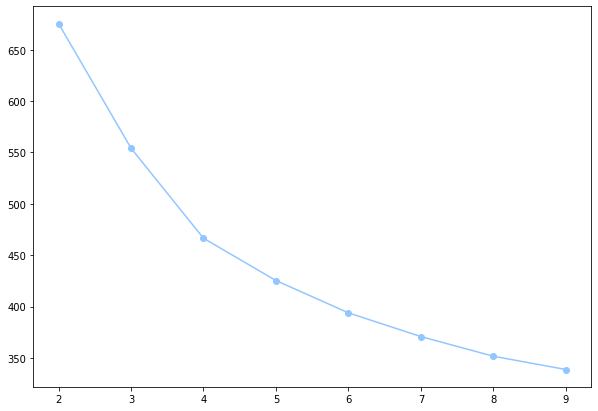

In [14]:
scores = []
for n_clusters in range(2, 10):
    model = KMeans(n_clusters).fit(norm_df.copy())
    score_sse = model.inertia_
    scores.append(score_sse)

plt.plot(list(range(2, 10)), scores, marker='o')